## Gas Sensor Array Drift - Modeling

In [33]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt


In [34]:
seed = 10

### Load the data

In [35]:
dataset = pd.read_csv('../Dataset/dataset_new.csv')

In [72]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
11,13910.0,-0.854016,0.152239,-1.0,-0.963341,-0.904241,-0.802275,1.0
15,13910.0,0.814373,0.154773,-1.0,0.829059,0.857843,0.876448,1.0
16,13910.0,-0.177983,0.244992,-1.0,-0.365460,-0.213577,-0.031182,1.0
25,13910.0,-0.924911,0.061348,-1.0,-0.964990,-0.941293,-0.908077,1.0
27,13910.0,-0.971436,0.034259,-1.0,-0.989647,-0.978693,-0.960992,1.0
35,13910.0,-0.937673,0.044303,-1.0,-0.964819,-0.945350,-0.918781,1.0
36,13910.0,-0.977512,0.022682,-1.0,-0.983925,-0.979407,-0.972593,1.0
42,13910.0,-0.889185,0.065573,-1.0,-0.932492,-0.902693,-0.859333,1.0
67,13910.0,-0.798513,0.228608,-1.0,-0.960318,-0.879118,-0.713677,1.0
68,13910.0,-0.869138,0.150393,-1.0,-0.966523,-0.912061,-0.831908,1.0


In [36]:
# drop rows with missing values
dataset.dropna(inplace=True)
print(dataset.shape)

(13910, 27)


In [75]:
dataset.isnull().sum()

11        0
15        0
16        0
25        0
27        0
35        0
36        0
42        0
67        0
68        0
69        0
70        0
71        0
76        0
77        0
78        0
81        0
85        0
87        0
88        0
100       0
104       0
105       0
115       0
116       0
123       0
target    0
dtype: int64

In [37]:
dataset.target.unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [38]:
print(dataset.shape)
dataset.head()

(13910, 27)


,11,15,16,25,27,35,36,42,67,68,...,85,87,88,100,104,105,115,116,123,target
0,-0.983235,0.880771,-0.465786,-0.965757,-0.998345,-0.996478,-0.998516,-0.986391,-0.970262,-0.968339,...,0.961107,0.958817,-0.727604,-0.993608,-0.743961,-0.830349,-0.983651,-0.989825,-0.995176,1
1,-0.962950,0.878272,-0.442325,-0.959520,-0.996986,-0.993518,-0.997962,-0.975004,-0.938728,-0.967645,...,0.935384,0.960165,-0.704714,-0.996111,-0.698075,-0.790407,-0.963147,-0.986838,-0.989122,1
2,-0.940908,0.875730,-0.408138,-0.949129,-0.995487,-0.989789,-0.997069,-0.963492,-0.902022,-0.950903,...,0.901869,0.955267,-0.670622,-0.990856,-0.631462,-0.723606,-0.943451,-0.980710,-0.983409,1
3,-0.909435,0.875197,-0.403969,-0.947990,-0.992739,-0.984775,-0.995475,-0.948086,-0.846068,-0.852793,...,0.895511,0.956006,-0.666491,-0.990730,-0.619449,-0.709701,-0.918075,-0.972499,-0.976055,1
4,-0.910599,0.871636,-0.365080,-0.933673,-0.993158,-0.984050,-0.995536,-0.947605,-0.851349,-0.931227,...,0.857691,0.951931,-0.627637,-0.991723,-0.546051,-0.625176,-0.911484,-0.970903,-0.974309,1


## Correlation

In [76]:
cor = dataset.corr()
cor

,11,15,16,25,27,35,36,42,67,68,...,85,87,88,100,104,105,115,116,123,target
11,1.000000,-0.631851,0.494791,0.268800,0.041448,0.333237,0.119643,0.508382,0.948035,0.878325,...,-0.530108,-0.423808,0.581690,0.164247,0.553355,0.282909,0.187080,0.181915,0.213978,0.309404
15,-0.631851,1.000000,-0.426286,-0.350825,-0.044916,-0.203820,-0.079536,-0.361040,-0.643835,-0.712399,...,0.617541,0.797904,-0.475605,-0.089455,-0.377884,-0.351170,-0.183909,-0.204923,-0.193276,-0.224890
16,0.494791,-0.426286,1.000000,0.745535,0.529471,0.572159,0.239898,0.748839,0.504349,0.480899,...,-0.903263,-0.577458,0.977565,0.413728,0.875581,0.655866,0.797374,0.768137,0.787203,-0.196012
25,0.268800,-0.350825,0.745535,1.000000,0.511423,0.556256,0.382421,0.657826,0.331112,0.316122,...,-0.695724,-0.487211,0.718061,0.373299,0.635610,0.800193,0.631756,0.618211,0.656071,-0.243607
27,0.041448,-0.044916,0.529471,0.511423,1.000000,0.527566,0.423027,0.473273,0.046465,0.028961,...,-0.496871,-0.294295,0.534215,0.507766,0.455078,0.357687,0.711968,0.716926,0.728400,-0.354290
35,0.333237,-0.203820,0.572159,0.556256,0.527566,1.000000,0.736382,0.883513,0.389126,0.335283,...,-0.558221,-0.356924,0.576593,0.756476,0.669656,0.536903,0.616782,0.599641,0.683449,-0.340157
36,0.119643,-0.079536,0.239898,0.382421,0.423027,0.736382,1.000000,0.465014,0.147643,0.141619,...,-0.251640,-0.171477,0.254437,0.793552,0.285419,0.240237,0.320625,0.346772,0.440024,-0.174680
42,0.508382,-0.361040,0.748839,0.657826,0.473273,0.883513,0.465014,1.000000,0.554910,0.485596,...,-0.701559,-0.466754,0.749846,0.572101,0.885193,0.744298,0.620885,0.589397,0.654200,-0.254005
67,0.948035,-0.643835,0.504349,0.331112,0.046465,0.389126,0.147643,0.554910,1.000000,0.934320,...,-0.536448,-0.450447,0.576374,0.220567,0.561114,0.357732,0.231401,0.228128,0.263658,0.171308
68,0.878325,-0.712399,0.480899,0.316122,0.028961,0.335283,0.141619,0.485596,0.934320,1.000000,...,-0.500447,-0.509327,0.553680,0.185254,0.481821,0.328760,0.210502,0.228645,0.237345,0.210117


## Heatmap

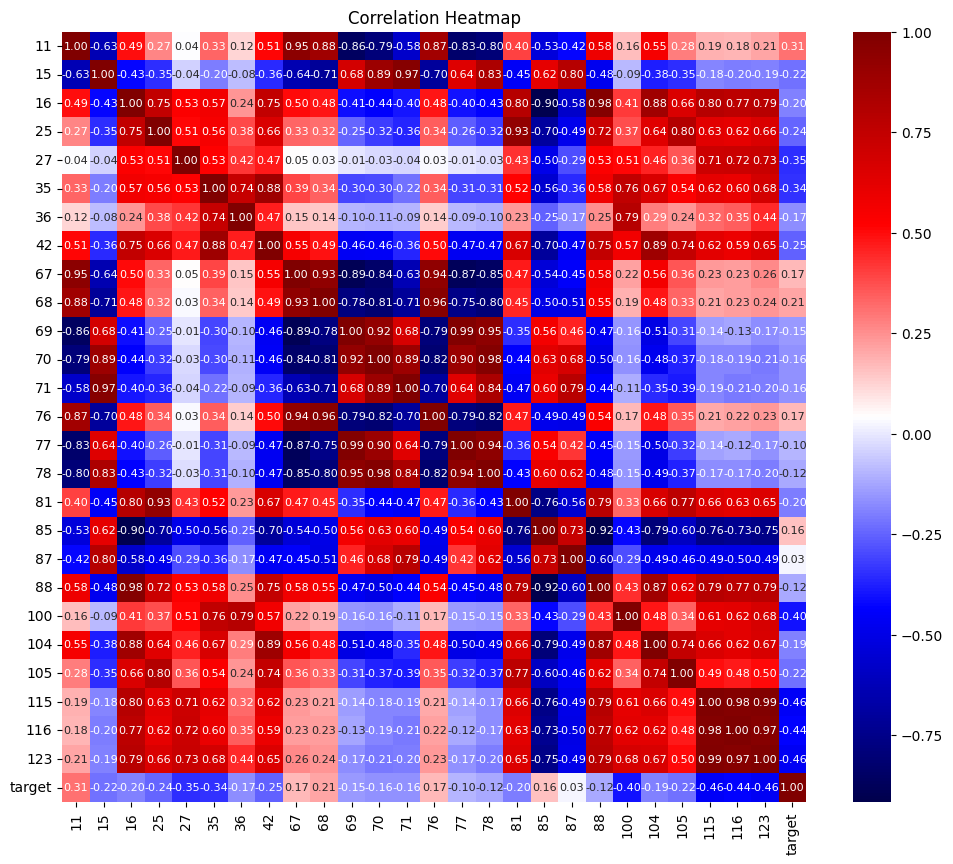

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))  # Increase figure size for better readability
sns.heatmap(cor, annot=True, cmap='seismic', fmt='.2f', annot_kws={"size": 8})  # Reduce annotation size
plt.title('Correlation Heatmap', fontsize=12)  # Reduce title font size
plt.show()


In [85]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910 entries, 0 to 13909
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   11      13910 non-null  float64
 1   15      13910 non-null  float64
 2   16      13910 non-null  float64
 3   25      13910 non-null  float64
 4   27      13910 non-null  float64
 5   35      13910 non-null  float64
 6   36      13910 non-null  float64
 7   42      13910 non-null  float64
 8   67      13910 non-null  float64
 9   68      13910 non-null  float64
 10  69      13910 non-null  float64
 11  70      13910 non-null  float64
 12  71      13910 non-null  float64
 13  76      13910 non-null  float64
 14  77      13910 non-null  float64
 15  78      13910 non-null  float64
 16  81      13910 non-null  float64
 17  85      13910 non-null  float64
 18  87      13910 non-null  float64
 19  88      13910 non-null  float64
 20  100     13910 non-null  float64
 21  104     13910 non-null  float64
 22

## Data Separation

In [86]:
X = dataset.drop('target', axis=1)
y = dataset.loc[:,'target']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [88]:
X_train.shape, X_test.shape

((11128, 26), (2782, 26))

## Best Parameter Selection for ML ALgorithm / Classification

In [41]:
kfold = StratifiedKFold(n_splits=10, random_state=20, shuffle=True)

In [42]:
X_train.shape

(11128, 26)

In [43]:
y_train.shape

(11128,)

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 1. KNeighborsClassifier

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train_scaled, X_test_scaled, y_train, and y_test are already defined and scaled

# Define the KNN classifier
knn = KNeighborsClassifier()

# Parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [5, 10, 15, 20],  # Example values, adjust as needed
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Perform Grid Search CV with 10 folds
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit the grid search on scaled data
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and best score
best_params_knn = grid_search.best_params_
best_score_knn = grid_search.best_score_

# Train with best parameters
best_knn = KNeighborsClassifier(**best_params_knn)
training_start = time.perf_counter()
best_knn.fit(X_train_scaled, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
# Obtain predictions on the test set
preds_knn = best_knn.predict(X_test_scaled)
prediction_end = time.perf_counter()

# Evaluate accuracy on the test set
#acc_knn = best_knn.score(X_test_scaled, y_test)


acc_knn = (preds_knn == y_test).sum().astype(float) / len(preds_knn)

KNN_train_time = training_end - training_start
KNN_prediction_time = prediction_end - prediction_start

# Print results
print("K Nearest Neighbors Classifier's best parameters:", best_params_knn)
print("K Nearest Neighbors Classifier's prediction accuracy:", acc_knn)
print("Time consumed for training: %4.3f seconds" % (KNN_train_time))
print("Time consumed for prediction: %6.5f seconds" % (KNN_prediction_time))



KeyboardInterrupt: 

In [132]:
from sklearn.metrics import classification_report

report = classification_report(y_test, preds_knn, digits=4)
print("\nClassification Report for KNeighborsClassifier :\n", report)
print("***************************************************************")


Classification Report for KNeighborsClassifier :
               precision    recall  f1-score   support

           1     0.9981    0.9943    0.9962       528
           2     0.9935    1.0000    0.9967       611
           3     0.9967    0.9805    0.9885       307
           4     0.9863    0.9972    0.9917       360
           5     0.9931    0.9931    0.9931       579
           6     0.9949    0.9924    0.9937       397

    accuracy                         0.9939      2782
   macro avg     0.9938    0.9929    0.9933      2782
weighted avg     0.9939    0.9939    0.9939      2782

***************************************************************


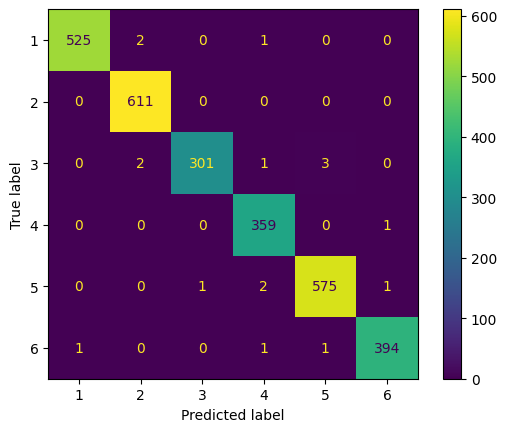

In [134]:


from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_knn,X_test_scaled,y_test)

### 2. GaussianNB

In [142]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_scaled, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds_gau = gnb.predict(X_test_scaled) 
prediction_end = time.perf_counter()

# Calculate accuracy
acc_gnb = (preds_gau == y_test).sum().astype(float) / len(y_test)  # Compare with y_test, not preds
gnb_train_time = training_end - training_start
gnb_prediction_time = prediction_end - prediction_start

print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.4f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 0.5823
Time consumed for training: 0.015 seconds
Time consumed for prediction: 0.00311 seconds


In [110]:
from sklearn.metrics import classification_report

report = classification_report(y_test, preds_gau, digits=4)
print("\nClassification Report for KNeighborsClassifier :\n", report)
print("***************************************************************")




Classification Report for KNeighborsClassifier :
               precision    recall  f1-score   support

           1     0.7098    0.6439    0.6753       528
           2     0.9258    0.6530    0.7658       611
           3     0.6117    0.5440    0.5759       307
           4     0.3265    0.3083    0.3171       360
           5     0.7752    0.4646    0.5810       579
           6     0.3662    0.8413    0.5103       397

    accuracy                         0.5823      2782
   macro avg     0.6192    0.5759    0.5709      2782
weighted avg     0.6614    0.5823    0.5947      2782

***************************************************************


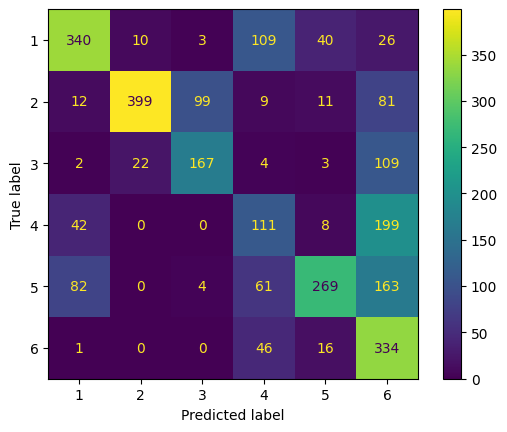

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gnb,X_test_scaled,y_test)

## 3. XGBoost

In [143]:
from xgboost import XGBClassifier
import time

# Assuming y_train has values starting from 1 and ending at 6
# Subtract 1 to adjust class labels to start from 0
y_train_adjusted = y_train - 1

# Define the XGBoost classifier
xgb = XGBClassifier(objective='multi:softmax', num_class=6, eval_metric='mlogloss')

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],  # Adjusted learning rates
    'max_depth': [3, 5, 7],
}

# Perform Grid Search CV with 10 folds
grid_search = GridSearchCV(xgb, param_grid, cv=10, scoring='accuracy')

# Fit the grid search on scaled data
grid_search.fit(X_train_scaled, y_train_adjusted)

# Get best parameters and best score
best_params_xgb = grid_search.best_params_
best_score_xgb = grid_search.best_score_

# Train with best parameters
best_xgb = XGBClassifier(objective='multi:softmax', num_class=6, eval_metric='mlogloss', **best_params_xgb)

training_start = time.perf_counter()
best_xgb.fit(X_train_scaled, y_train_adjusted)
training_end = time.perf_counter()

# Obtain predictions on the test set
prediction_start = time.perf_counter()
preds_xgb = best_xgb.predict(X_test_scaled)
prediction_end = time.perf_counter()

# Evaluate accuracy on the test set
acc_xgb = (preds_xgb == y_test).sum().astype(float) / len(preds_xgb)*100
xgb_train_time = training_end - training_start
xgb_prediction_time = prediction_end - prediction_start


# Print results
print("XGBoost Classifier's best parameters:", best_params_xgb)
print("XGBoost Classifier's prediction accuracy:", acc_xgb)
print("Time consumed for training: %4.3f seconds" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost Classifier's best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
XGBoost Classifier's prediction accuracy: 0.14378145219266716
Time consumed for training: 4.102 seconds
Time consumed for prediction: 0.03730 seconds


In [144]:
from sklearn.metrics import classification_report


report = classification_report(y_test, preds_xgb, digits=4)
print("\nClassification Report for KNeighborsClassifier :\n", report)
print("***************************************************************")


Classification Report for KNeighborsClassifier :
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0033    0.0038    0.0035       528
           2     0.0000    0.0000    0.0000       611
           3     0.0027    0.0033    0.0030       307
           4     0.0000    0.0000    0.0000       360
           5     0.0025    0.0017    0.0021       579
           6     0.0000    0.0000    0.0000       397

    accuracy                         0.0014      2782
   macro avg     0.0012    0.0013    0.0012      2782
weighted avg     0.0014    0.0014    0.0014      2782

***************************************************************


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.p

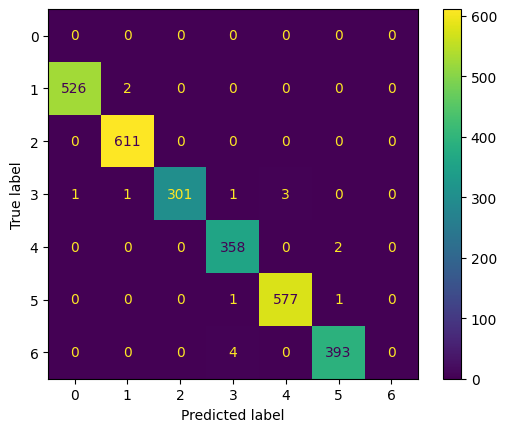

In [145]:

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_xgb,X_test_scaled,y_test)

## 4. Radom Forest Classifier

In [ ]:
folds = 10
param_grid = {
    'n_estimators': [50, 100, 150],  # Example values, adjust as needed
    'max_depth': [None, 10, 20],  # Example values, adjust as needed
    'min_samples_split': [2, 5, 10],  # Example values, adjust as needed
}


# Define the RandomForestClassifier
rfc = RandomForestClassifier()

# Perform Grid Search CV with 10 folds
grid_search = GridSearchCV(rfc, param_grid, cv=folds, scoring='accuracy')

# Fit the grid search on scaled data
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and best score
best_params_rfc = grid_search.best_params_
best_score_rfc = grid_search.best_score_

# Train with best parameters
best_rfc = RandomForestClassifier(**best_params_rfc)
best_rfc.fit(X_train_scaled, y_train)

# Evaluate on test set
acc_rfc = best_rfc.score(X_test_scaled, y_test)

# Print results
print("Random Forest Classifier's best parameters:", best_params_rfc)
print("Random Forest Classifier's best accuracy:", best_score_rfc)
print("Random Forest Classifier's prediction accuracy:", acc_rfc)

In [116]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds_rfc = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds_rfc == y_test).sum().astype(float) / len(preds_rfc)
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.6f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 0.992092
Time consumed for training: 0.697 seconds
Time consumed for prediction: 0.00646 seconds


In [117]:
from sklearn.metrics import classification_report

report = classification_report(y_test, preds_rfc, digits=4)
print("\nClassification Report for KNeighborsClassifier :\n", report)
print("***************************************************************")


Classification Report for KNeighborsClassifier :
               precision    recall  f1-score   support

           1     0.9981    0.9962    0.9972       528
           2     0.9951    0.9984    0.9967       611
           3     1.0000    0.9805    0.9901       307
           4     0.9781    0.9917    0.9848       360
           5     0.9931    0.9931    0.9931       579
           6     0.9849    0.9849    0.9849       397

    accuracy                         0.9921      2782
   macro avg     0.9915    0.9908    0.9911      2782
weighted avg     0.9921    0.9921    0.9921      2782

***************************************************************


c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


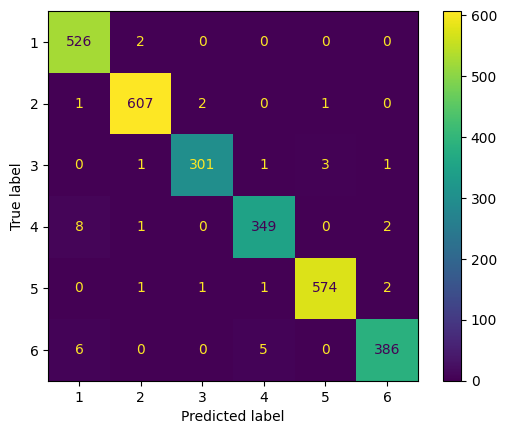

In [118]:




from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rfc,X_test_scaled,y_test)

## 5. Support Vector Machine Classifier

In [113]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds_svc = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds_svc == y_test).sum().astype(float) / len(preds_svc)
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.4f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 0.8760
Time consumed for training: 6.773 seconds
Time consumed for prediction: 4.22243 seconds


In [114]:
from sklearn.metrics import classification_report

report = classification_report(y_test, preds_svc, digits=4)
print("\nClassification Report for KNeighborsClassifier :\n", report)
print("***************************************************************")





Classification Report for KNeighborsClassifier :
               precision    recall  f1-score   support

           1     0.9648    0.9356    0.9500       528
           2     0.9946    0.9116    0.9513       611
           3     0.9964    0.8925    0.9416       307
           4     0.8589    0.5750    0.6889       360
           5     0.9829    0.8912    0.9348       579
           6     0.5815    0.9798    0.7298       397

    accuracy                         0.8760      2782
   macro avg     0.8965    0.8643    0.8661      2782
weighted avg     0.9102    0.8760    0.8810      2782

***************************************************************


c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


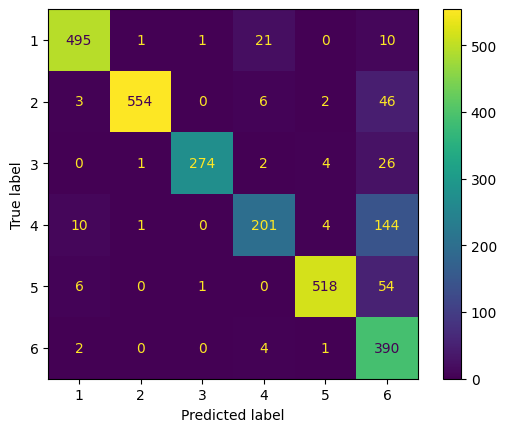

In [115]:

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc,X_test_scaled,y_test)

In [122]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,0.992092,0.696840,0.006458
KNN,0.991733,0.005023,0.441416
SVC,0.875988,6.773038,4.222427
Naive Bayes,0.582315,0.011404,0.002545
XGBoost,0.001797,2.547833,0.140864
